In [12]:
import warnings

In [13]:
warnings.filterwarnings("ignore")

In [14]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [15]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
data = pd.read_csv("../NullValueHandled/MataraDeniyayaHandledNullValues.csv", index_col=0, parse_dates=True)

In [17]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000006
2019-01-02,2019-01-03,0.000006
2019-01-03,2019-01-04,0.000236
2019-01-04,2019-01-05,0.000064
2019-01-05,2019-01-06,0.000053


In [7]:
matara_data = data[["HCHO reading"]]
matara_data.head()  

,HCHO reading
Current Date,
2019-01-01,0.000006
2019-01-02,0.000006
2019-01-03,0.000236
2019-01-04,0.000064
2019-01-05,0.000053


In [7]:
matara_data.shape   

(1826, 1)

In [8]:
X = matara_data.values   

#### This looks like that Matara fomaldihyde rates have a small seasonality

<Axes: xlabel='Current Date'>

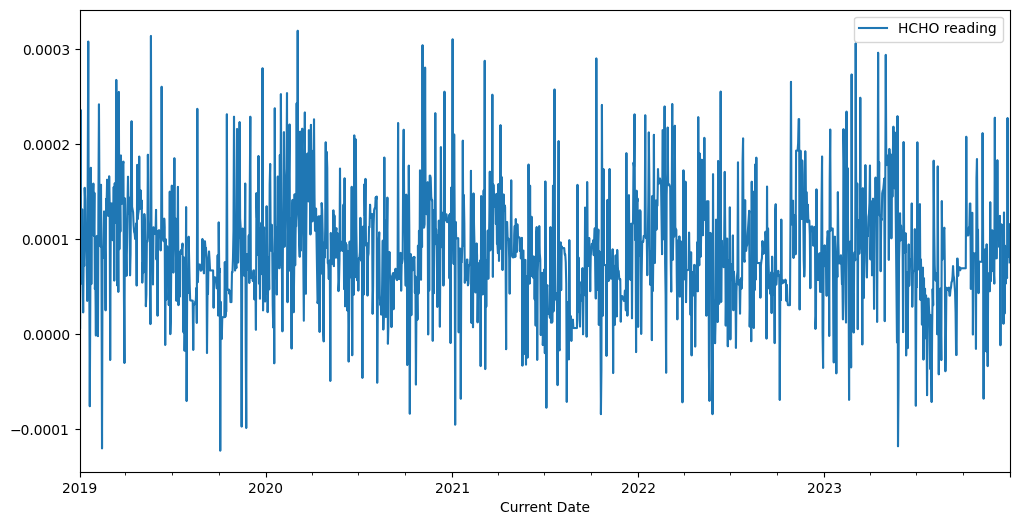

In [10]:
matara_data.plot(figsize=(12, 6))  

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
test_matara = adfuller(matara_data["HCHO reading"], autolag="AIC")  

In [13]:
print("ADF value : ", test_matara[0])
print("P value: ", test_matara[1])
print("Num of Lags :", test_matara[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_matara[3])
for key, val in test_matara[4].items():
    print("\t", key, ": ", val)

ADF value :  -6.235921108894503
P value:  4.826071467176593e-08
Num of Lags : 15
Num of Observations used for ADF Regression and Critical Calculation : 1810
	 1% :  -3.433968010099092
	 5% :  -2.8631381499714745
	 10% :  -2.567620802173316


#### Auto correlation and correlation plot for Matara

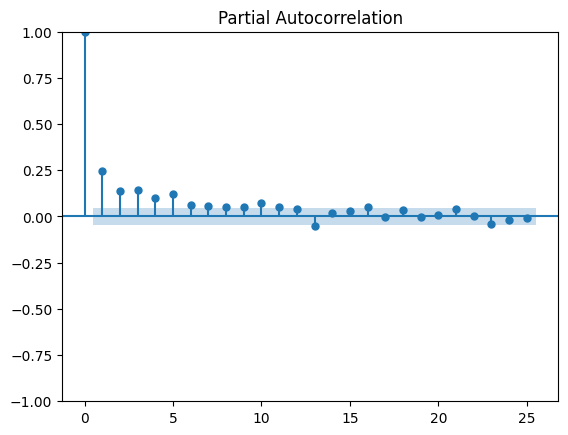

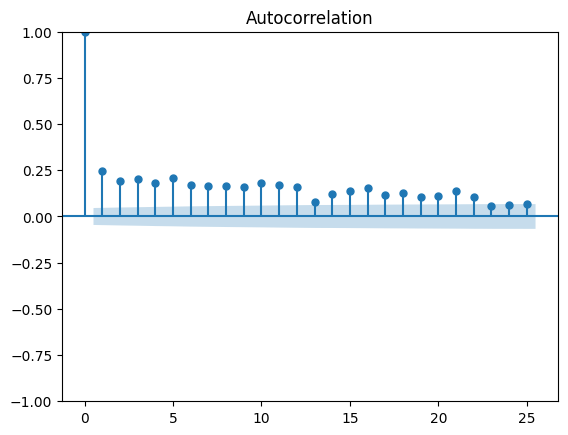

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(matara_data["HCHO reading"], lags=25)
acf = plot_acf(matara_data["HCHO reading"], lags=25)   

#### There is a small seasanolity and stationarity in Matara Data

#### Matara with LSTM

In [12]:
data = pd.read_csv("../NullValueHandled/MataraDeniyayaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [13]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000006
1   2019-01-02      0.000006
2   2019-01-03      0.000236
3   2019-01-04      0.000064
4   2019-01-05      0.000053


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 52s 301ms/step - loss: 1.1676 - mean_squared_error: 1.1676 - val_loss: 0.7684 - val_mean_squared_error: 0.7684
Epoch 2/100
37/37 [==============================] - 5s 129ms/step - loss: 0.9826 - mean_squared_error: 0.9826 - val_loss: 0.8025 - val_mean_squared_error: 0.8025
Epoch 3/100
37/37 [==============================] - 5s 128ms/step - loss: 0.9519 - mean_squared_error: 0.9519 - val_loss: 0.8866 - val_mean_squared_error: 0.8866
Epoch 4/100
37/37 [==============================] - 5s 124ms/step - loss: 0.9591 - mean_squared_error: 0.9591 - val_loss: 0.8255 - val_mean_squared_error: 0.8255
Epoch 5/100
37/37 [==============================] - 5s 130ms/step - loss: 0.9351 - mean_squared_error: 0.9351 - val_loss: 0.8442 - val_mean_squared_error: 0.8442
Epoch 6/100
37/37 [==============================] - 5s 130ms/step - loss: 0.9450 - mean_squared_error: 0.9450 - val_loss: 0.8032 - val_mean_squared_error: 0.8032
Epoch 7/100
37/37 [==

37/37 [==============================] - 5s 138ms/step - loss: 0.7964 - mean_squared_error: 0.7964 - val_loss: 0.9166 - val_mean_squared_error: 0.9166
Epoch 52/100
37/37 [==============================] - 5s 132ms/step - loss: 0.8213 - mean_squared_error: 0.8213 - val_loss: 0.8467 - val_mean_squared_error: 0.8467
Epoch 53/100
37/37 [==============================] - 5s 134ms/step - loss: 0.7905 - mean_squared_error: 0.7905 - val_loss: 0.8804 - val_mean_squared_error: 0.8804
Epoch 54/100
37/37 [==============================] - 5s 137ms/step - loss: 0.7825 - mean_squared_error: 0.7825 - val_loss: 0.8552 - val_mean_squared_error: 0.8552
Epoch 55/100
37/37 [==============================] - 5s 139ms/step - loss: 0.8226 - mean_squared_error: 0.8226 - val_loss: 0.8341 - val_mean_squared_error: 0.8341
Epoch 56/100
37/37 [==============================] - 6s 158ms/step - loss: 0.8427 - mean_squared_error: 0.8427 - val_loss: 0.8773 - val_mean_squared_error: 0.8773
Epoch 57/100
37/37 [=========

12/12 [==============================] - 15s 46ms/step


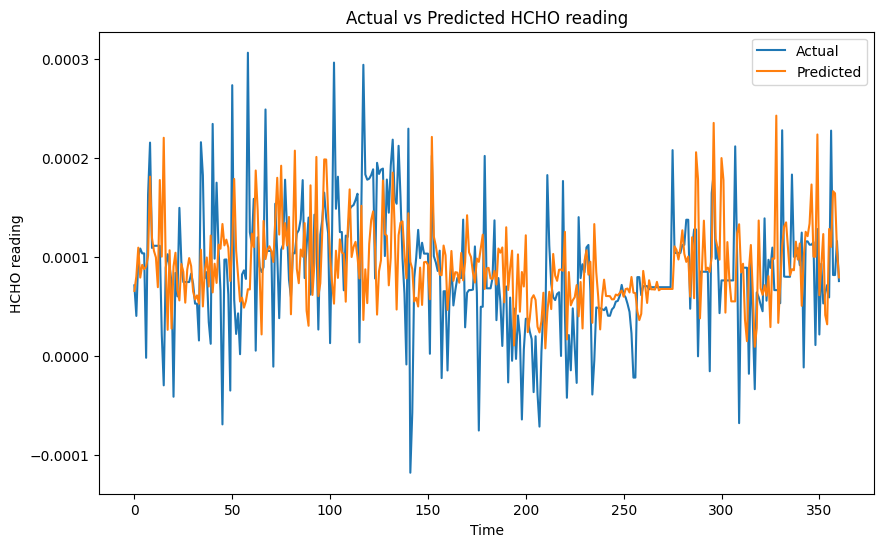

In [15]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 30ms/step


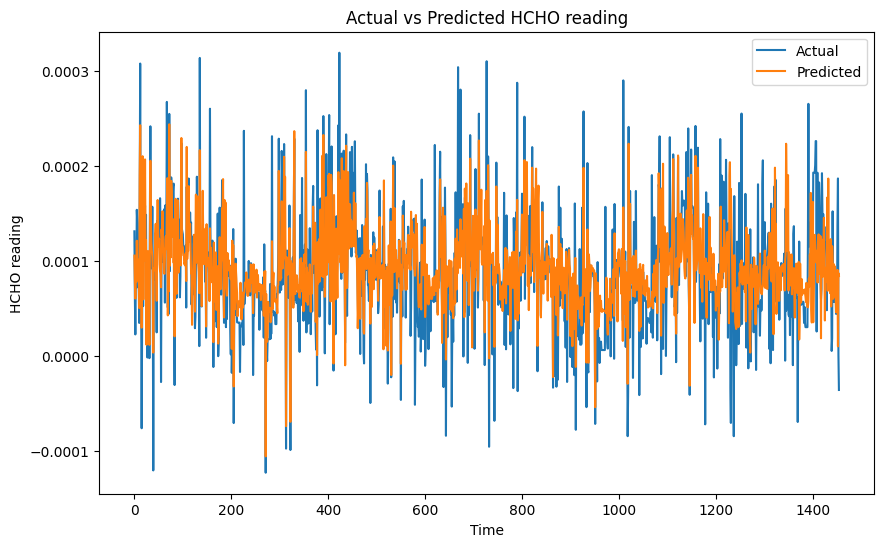

In [16]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 31ms/step


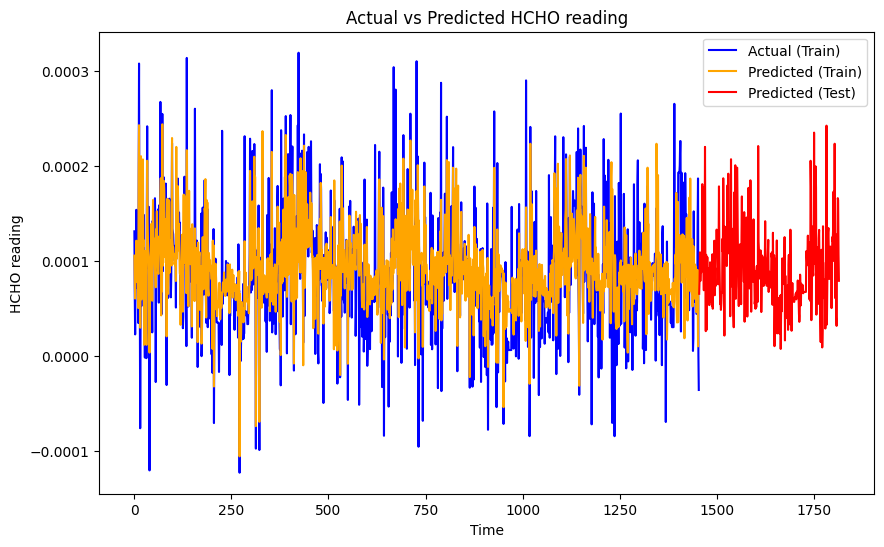

In [17]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [18]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.48869297695397773
Mean Absolute Error (MAE): 2.950383432736348e-05
Mean Squared Error (MSE): 1.8183295494729248e-09
Root Mean Squared Error (RMSE): 4.264187553887522e-05
Median Absolute Error: 1.9997588804808884e-05
Explained Variance Score: 0.4936697144052463


#### FaceBook Prophet for Matara Deniyaya

23:45:44 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing


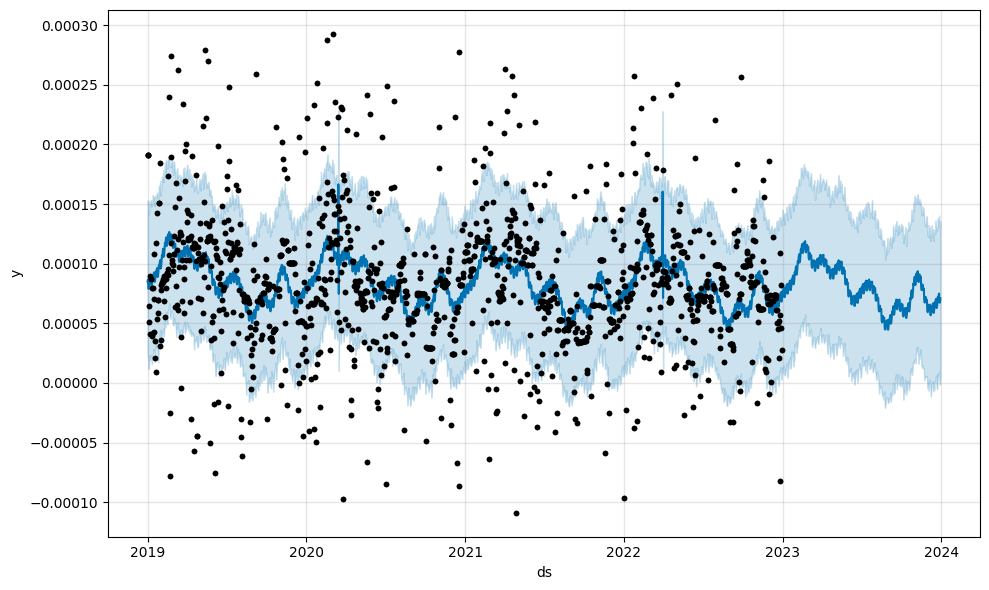

In [29]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2022-03-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.80 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365, 
                                    )

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

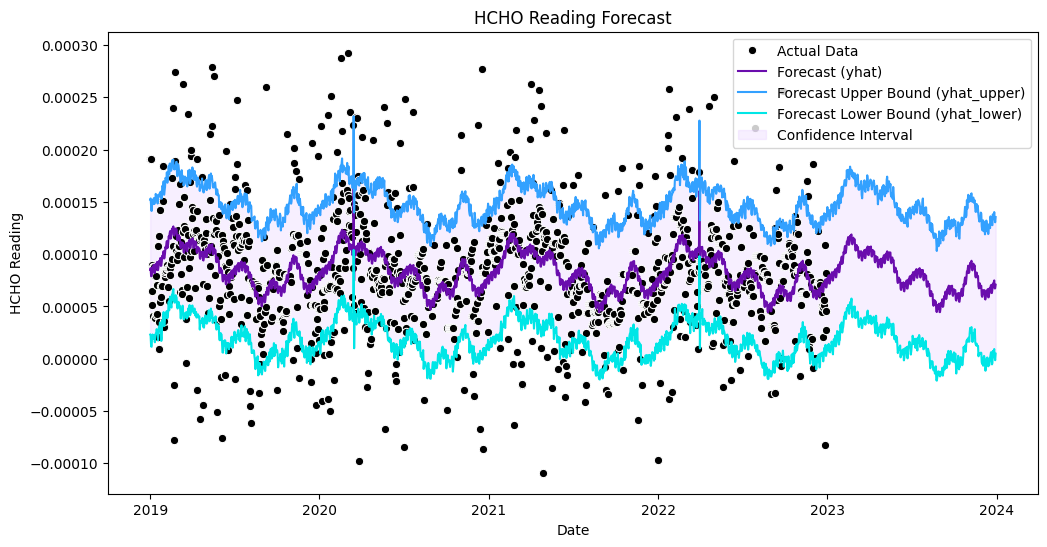

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

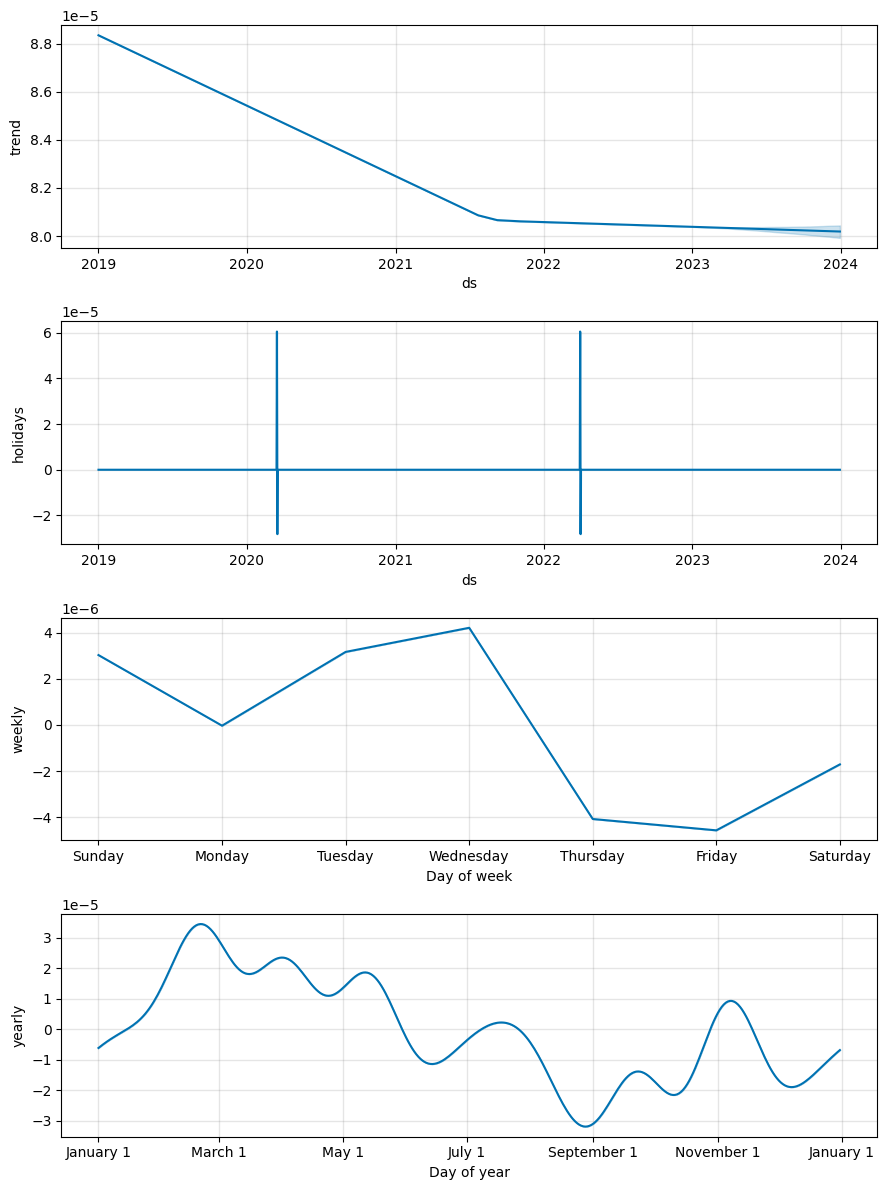

In [31]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [34]:
from tabulate import tabulate

y_test = test_data['y'][:-1]
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.020566660431041717
Mean Absolute Error (MAE): 4.072143774072999e-05
Mean Squared Error (MSE): 3.421744828337752e-09
Root Mean Squared Error (RMSE): 5.8495682134134925e-05
Median Absolute Error: 2.8039746165212754e-05
Explained Variance Score: -0.0157914092730993


#### Matara Multi Variate Model

In [30]:
data = pd.read_csv("../AnalysedFinalData/mataraData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   int64  
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   int64  
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [32]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000006,"Deniyaya, Matara",6.34,80.55,7,0.27,79.340,84.398,75.560,863000,1283,672.64,0,0.034421,0.000013,0.115856,0,0,Before,Before
1,2019-01-02,0.000006,"Deniyaya, Matara",6.34,80.55,7,0.06,78.440,83.318,74.516,863000,1283,672.64,0,0.035665,0.000017,0.115856,0,0,Before,Before
2,2019-01-03,0.000236,"Deniyaya, Matara",6.34,80.55,7,0.03,78.728,84.074,74.264,863000,1283,672.64,0,0.033910,0.000017,0.115856,0,0,Before,Before
3,2019-01-04,0.000064,"Deniyaya, Matara",6.34,80.55,7,0.02,78.368,83.642,73.688,863000,1283,672.64,0,0.038113,0.000019,0.115856,0,0,Before,Before
4,2019-01-05,0.000053,"Deniyaya, Matara",6.34,80.55,7,0.09,79.070,85.118,73.670,863000,1283,672.64,0,0.033754,0.000019,0.115856,0,0,Before,Before


#### remove constant data

In [33]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [34]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [35]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000006,0.27,79.340,84.398,75.560,863000,672.64,0.034421,0.000013,0.115856,0,0,Before,Before
1,2019-01-02,0.000006,0.06,78.440,83.318,74.516,863000,672.64,0.035665,0.000017,0.115856,0,0,Before,Before
2,2019-01-03,0.000236,0.03,78.728,84.074,74.264,863000,672.64,0.033910,0.000017,0.115856,0,0,Before,Before
3,2019-01-04,0.000064,0.02,78.368,83.642,73.688,863000,672.64,0.038113,0.000019,0.115856,0,0,Before,Before
4,2019-01-05,0.000053,0.09,79.070,85.118,73.670,863000,672.64,0.033754,0.000019,0.115856,0,0,Before,Before


#### Encode Categorical data

In [36]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [37]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000006,0.27,79.340,84.398,75.560,863000,672.64,0.034421,0.000013,0.115856,0,0,1,1
1,2019-01-02,0.000006,0.06,78.440,83.318,74.516,863000,672.64,0.035665,0.000017,0.115856,0,0,1,1
2,2019-01-03,0.000236,0.03,78.728,84.074,74.264,863000,672.64,0.033910,0.000017,0.115856,0,0,1,1
3,2019-01-04,0.000064,0.02,78.368,83.642,73.688,863000,672.64,0.038113,0.000019,0.115856,0,0,1,1
4,2019-01-05,0.000053,0.09,79.070,85.118,73.670,863000,672.64,0.033754,0.000019,0.115856,0,0,1,1


#### Check correlations

In [38]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr

,HCHO reading
HCHO reading,1.000000
PRCP,-0.033231
TAVG,0.082761
TMAX,0.177749
TMIN,-0.063090
Population,-0.053554
population_density,-0.053554
carbon_monoxide,0.248222
nitogen_dioxide,0.155423
ozone,-0.089257


In [39]:
corr.to_csv("../OtherData/MataraCorrelationData.csv") 

In [40]:
data.shape

(1826, 15)

#### remove covid range status

In [41]:
data.drop(columns=["covid_range_status"], inplace=True)

#### Devide X and Y

In [42]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [43]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status
0,2019-01-01,0.27,79.340,84.398,75.560,863000,672.64,0.034421,0.000013,0.115856,0,0,1
1,2019-01-02,0.06,78.440,83.318,74.516,863000,672.64,0.035665,0.000017,0.115856,0,0,1
2,2019-01-03,0.03,78.728,84.074,74.264,863000,672.64,0.033910,0.000017,0.115856,0,0,1
3,2019-01-04,0.02,78.368,83.642,73.688,863000,672.64,0.038113,0.000019,0.115856,0,0,1
4,2019-01-05,0.09,79.070,85.118,73.670,863000,672.64,0.033754,0.000019,0.115856,0,0,1


#### Select features based on Correlations

In [44]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.033231
TAVG                    0.082761
TMAX                    0.177749
TMIN                   -0.063090
Population             -0.053554
population_density     -0.053554
carbon_monoxide         0.248222
nitogen_dioxide         0.155423
ozone                  -0.089257
new_covid_patients     -0.124086
total_covid_patients   -0.055990
lockdown_status        -0.032355
Name: HCHO reading, dtype: float64

In [45]:
X = X[["Current Date", "carbon_monoxide", "nitogen_dioxide", "new_covid_patients", "TMAX"]]
X.head() 

,Current Date,carbon_monoxide,nitogen_dioxide,new_covid_patients,TMAX
0,2019-01-01,0.034421,0.000013,0,84.398
1,2019-01-02,0.035665,0.000017,0,83.318
2,2019-01-03,0.033910,0.000017,0,84.074
3,2019-01-04,0.038113,0.000019,0,83.642
4,2019-01-05,0.033754,0.000019,0,85.118


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Current Date        1826 non-null   object 
 1   carbon_monoxide     1826 non-null   float64
 2   nitogen_dioxide     1826 non-null   float64
 3   new_covid_patients  1826 non-null   int64  
 4   TMAX                1826 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 71.5+ KB


#### Standardize, variable data

In [91]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide", "nitogen_dioxide", "TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [92]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   nitogen_dioxide  1826 non-null   float64
 2   TMAX             1826 non-null   float64
dtypes: float64(3)
memory usage: 57.1 KB


##### Standardize target variable

In [93]:
y = data['HCHO reading']

y.head()

0    0.000006
1    0.000006
2    0.000236
3    0.000064
4    0.000053
Name: HCHO reading, dtype: float64

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [95]:
X_scaled = X

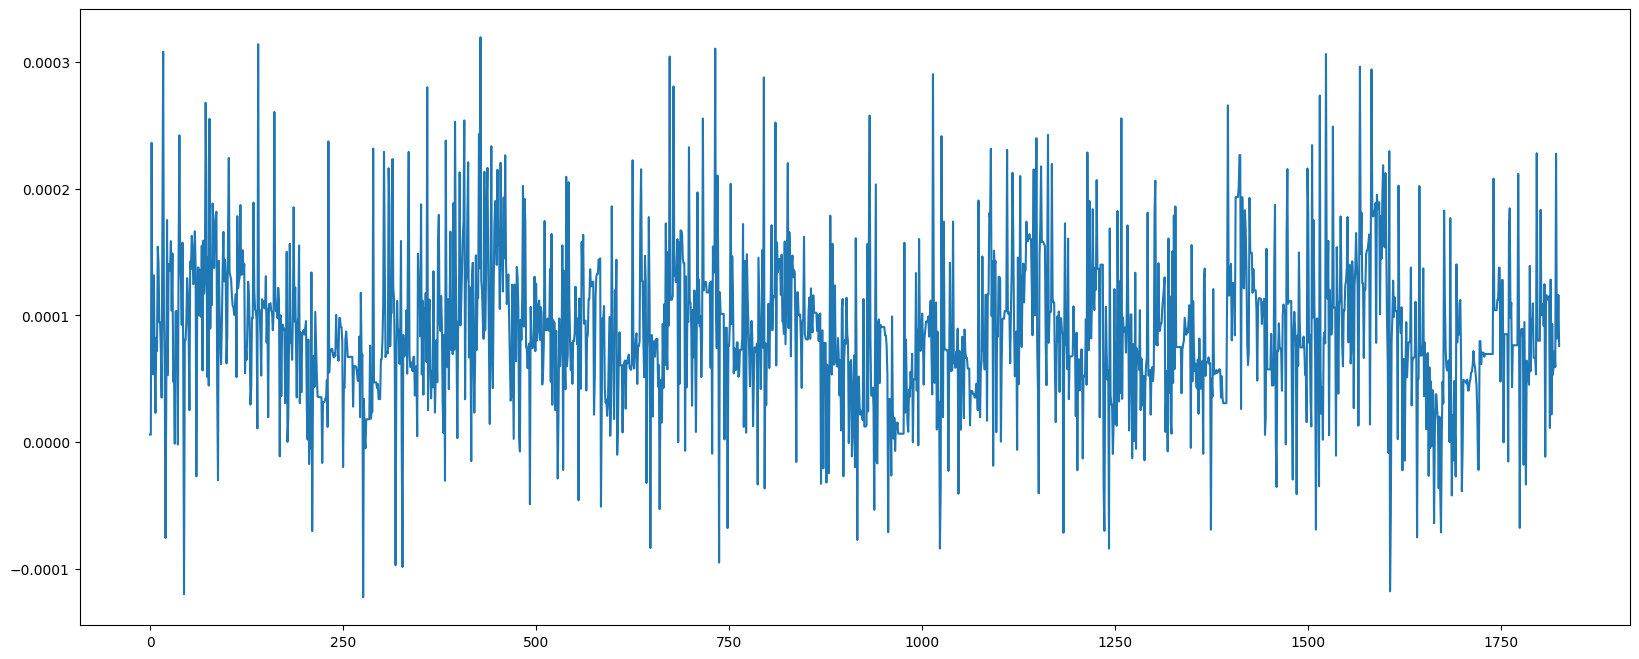

In [96]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [97]:
print(X_scaled.head())

              carbon_monoxide  nitogen_dioxide      TMAX
Current Date                                            
2019-01-01           0.720730         0.019158  0.202610
2019-01-02           0.925758         0.535860 -0.450654
2019-01-03           0.636407         0.541221  0.006630
2019-01-04           1.329390         0.843722 -0.254675
2019-01-05           0.610689         0.827827  0.638119


#### Apply multivariate time series model

In [125]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]


X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential([
    Bidirectional(LSTM(units=400, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10, activation="tanh")),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = Adam(learning_rate=0.008)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/150
12/12 [==============================] - 14s 269ms/step - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 2/150
12/12 [==============================] - 0s 27ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 3/150
12/12 [==============================] - 0s 28ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 4/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 5/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 6/150
12/12 [==============================] - 0s 24ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 7/150
12/12 [=======

12/12 [==============================] - 0s 25ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 102/150
12/12 [==============================] - 0s 25ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 103/150
12/12 [==============================] - 0s 24ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 104/150
12/12 [==============================] - 0s 23ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 105/150
12/12 [==============================] - 0s 23ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 106/150
12/12 [==============================] - 0s 23ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 107/150
12/12 [=========

12/12 [==============================] - 0s 4ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Test Loss: [0.018819481134414673, 0.018819481134414673]
12/12 [==============================] - 2s 4ms/step


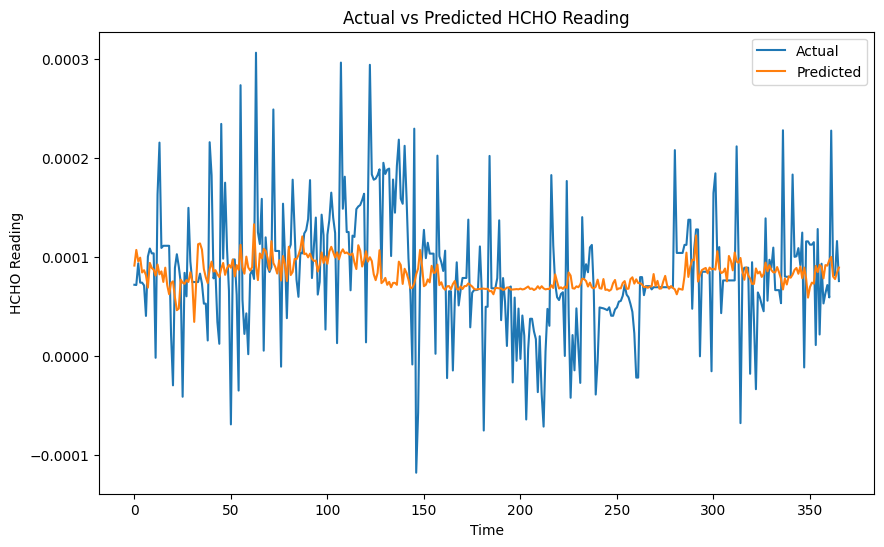

In [126]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 4ms/step


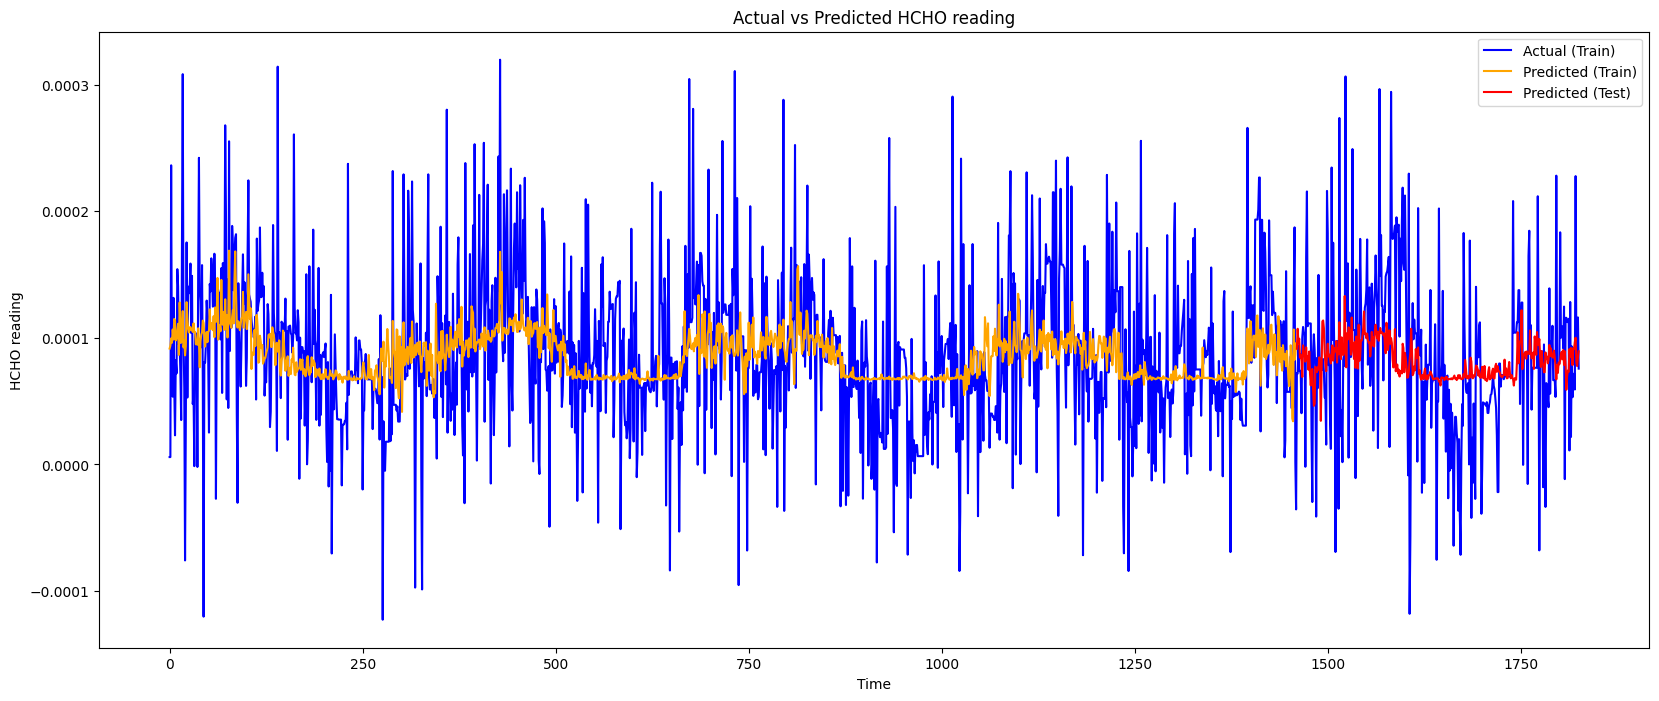

In [127]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [128]:
r2 = (r2_score(actual_test, predictions_test))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.07409274218454431
Mean Absolute Error (MAE): 4.3342009793802596e-05
Mean Squared Error (MSE): 3.6816369588670784e-09
Root Mean Squared Error (RMSE): 6.067649428623145e-05
Median Absolute Error: 2.9342448896164392e-05
Explained Variance Score: 0.07626445176401742


### Single Variate Time Series Models

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/mataraData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

data_dict = {
     'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_ar = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(3, 0, 0))  # AR model with p=1, d=0, q=0 (since it's AR)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]  # Forecasting 1 step ahead
    yhat_ar.append(predictions)

yhat_ar = pd.Series(yhat_ar, index=test.index)
ar_mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Print or store the results
print("ARIMA MSE:", ar_mse)


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [07:02<00:00,  1.15s/it]

ARIMA MSE: 3.4941697744713647e-09


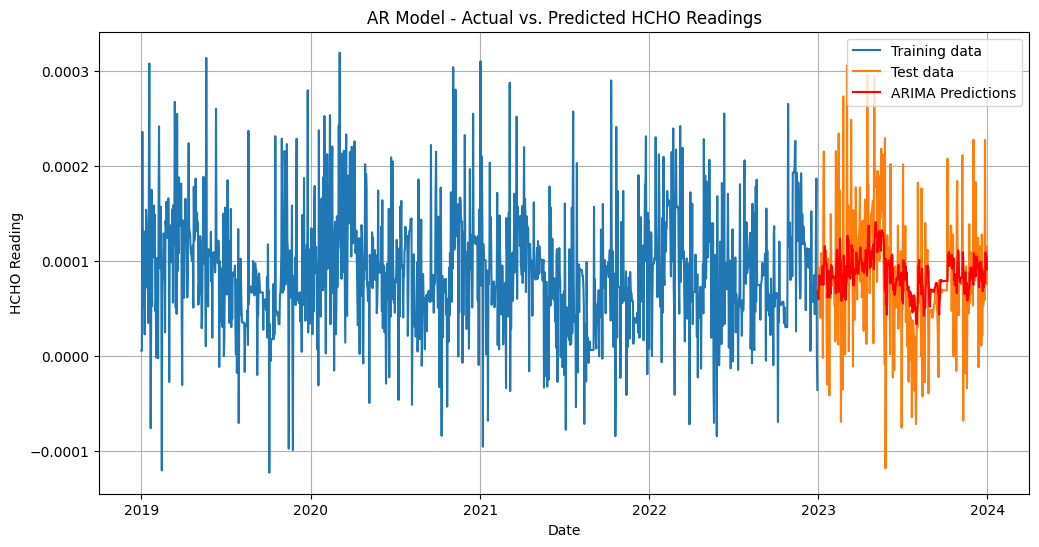

In [35]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('AR Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

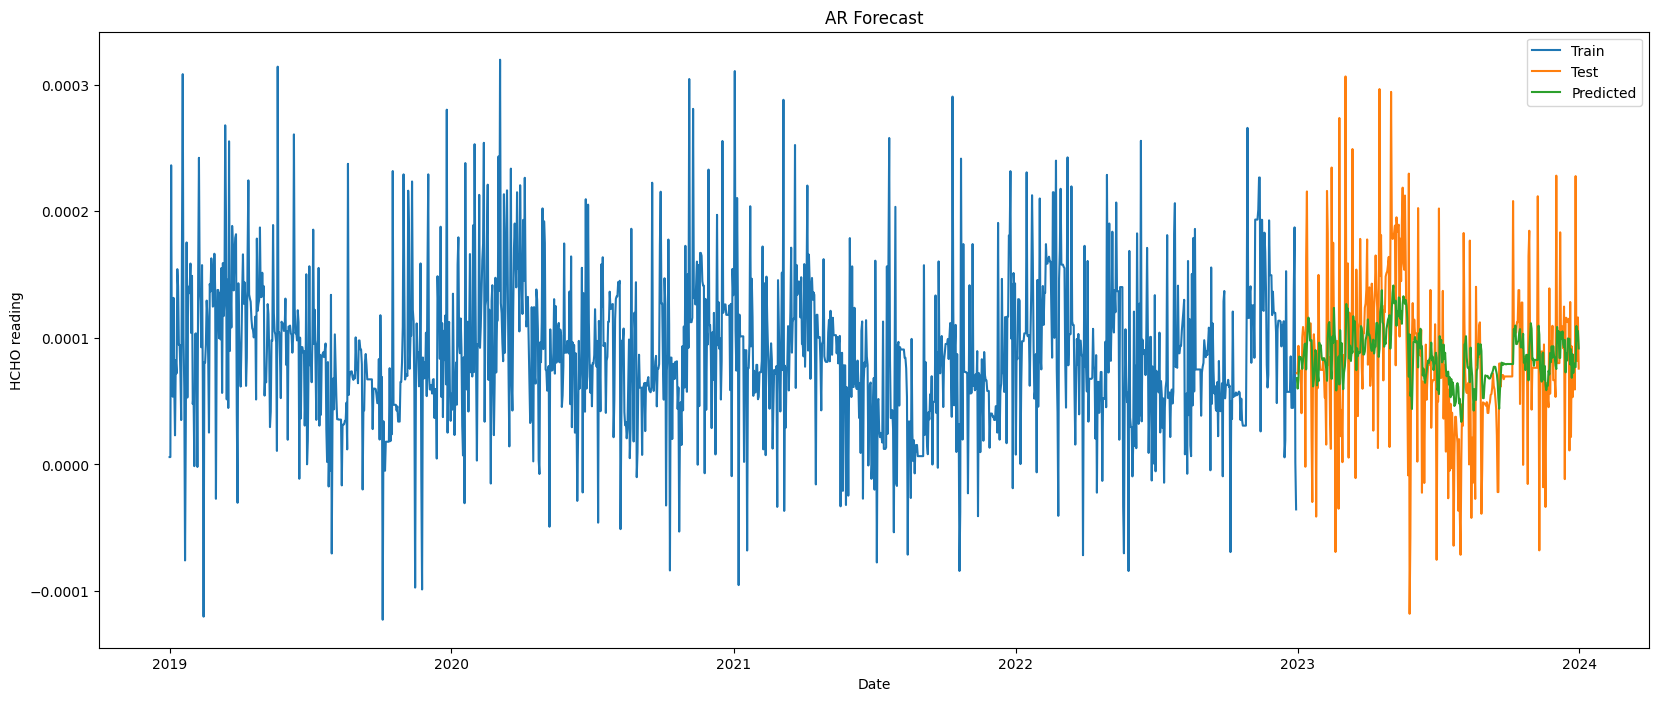

In [36]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train.index, train['HCHO reading'], label='Train')
plt.plot(test.index, test['HCHO reading'], label='Test')
plt.plot(test.index, yhat_ar, label='Predicted')

plt.title('AR Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO reading')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_ar)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_ar) 

rmse = mean_squared_error(test['HCHO reading'], yhat_ar, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_ar)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_ar) 


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.080773377545222e-05
Mean Squared Error (MSE): 3.4941697744713647e-09
R-squared (R2) Score: 0.12123949472247875
Root Mean Squared Error (RMSE): 5.911150289471047e-05
Median Absolute Error: 2.5536695995584585e-05
Explained Variance Score: 0.12189852861080264


####  ARIMA model

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/mataraData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
     'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example using auto_arima
model = auto_arima(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'nitrogen_dioxide', 'TMAX']],
                   seasonal=True, m=12,  # assuming monthly seasonality
                   trace=True)  # to display the model selection process
model_fit = model.fit(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'nitrogen_dioxide', 'TMAX']])

# Forecasting
forecast = model_fit.predict(n_periods=len(test), exogenous=test[['carbon_monoxide', 'nitrogen_dioxide', 'TMAX']])

# Calculating MSE
sarima_mse = mean_squared_error(test['HCHO reading'], forecast)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-24189.520, Time=5.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24250.892, Time=0.24 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23858.127, Time=3.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-24315.645, Time=4.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-22564.391, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-24287.489, Time=0.87 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-24173.536, Time=5.40 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-24314.367, Time=10.96 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-23867.369, Time=2.28 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=22.25 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-24283.280, Time=2.98 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24363.455, Time=5.54 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-24349.558, Time=1.08 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-24313.129, Time=5.97 

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/mataraData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
     'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_arma = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(5, 0, 0))  # ARMA model with p=1,d=0,  q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=10)[0]
    yhat_arma.append(predictions)

yhat_arma = pd.Series(yhat_arma, index=test.index)
arma_mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Print or store the results
print("ARIMA MSE:", arma_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [05:48<00:00,  1.05it/s]

ARIMA MSE: 3.411311282155624e-09


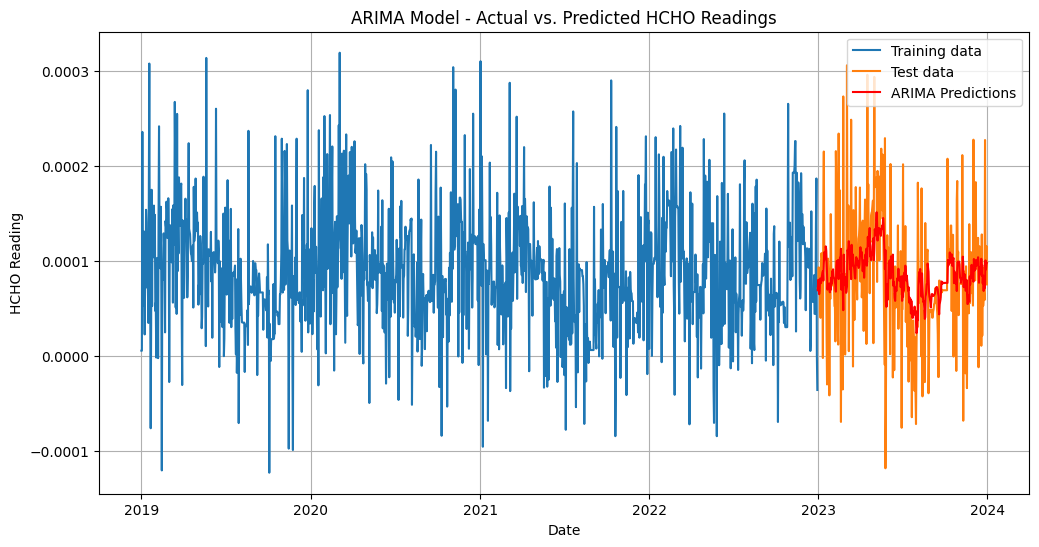

In [19]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

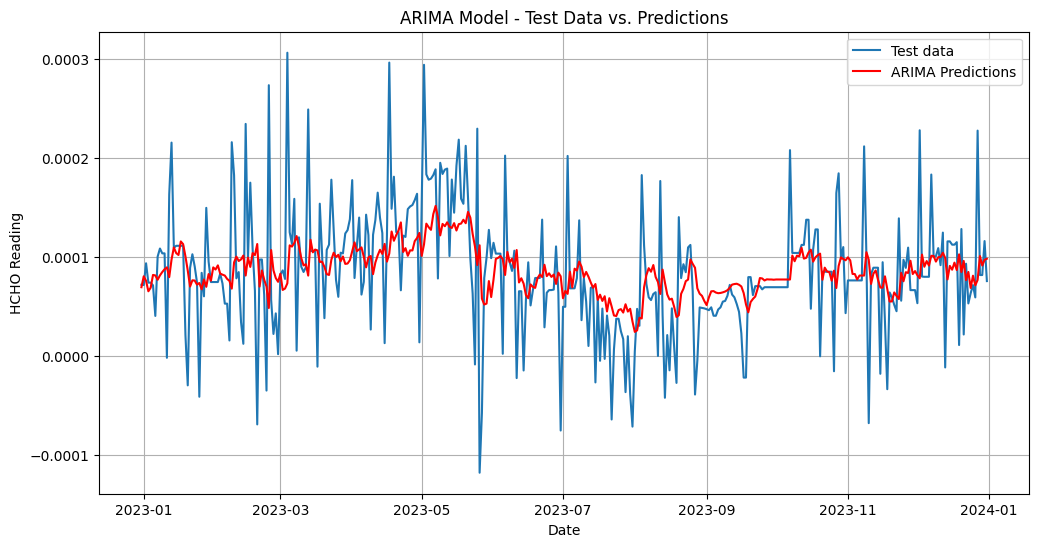

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 3.931678797789383e-05
Mean Squared Error (MSE): 3.411311282155624e-09
R-squared (R2) Score: 0.1420778555559702
Root Mean Squared Error (RMSE): 5.840643185605182e-05
Median Absolute Error: 2.292069853534717e-05
Explained Variance Score: 0.14241294604265797


#### Single variate SARIMA model

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/mataraData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example
yhat_sarima = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(5, 0, 0), seasonal_order=(0, 0, 0, 12))  # SARIMA model with p=1,d=0,q=1 and seasonal order (P,D,Q,s) = (1,0,1,12)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)  # Forecasting 10 steps ahead
    yhat_sarima.append(predictions[-1])  # Appending only the last value of the forecast

yhat_sarima = pd.Series(yhat_sarima, index=test.index)
sarima_mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [08:35<00:00,  1.41s/it]

SARIMA MSE: 3.6255613374741364e-09


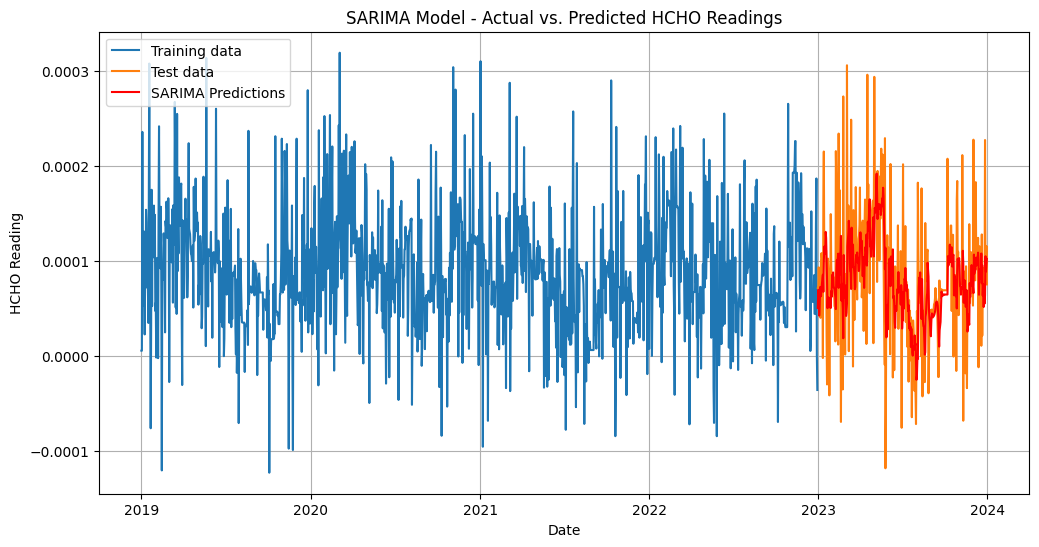

In [23]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True) 
plt.show()

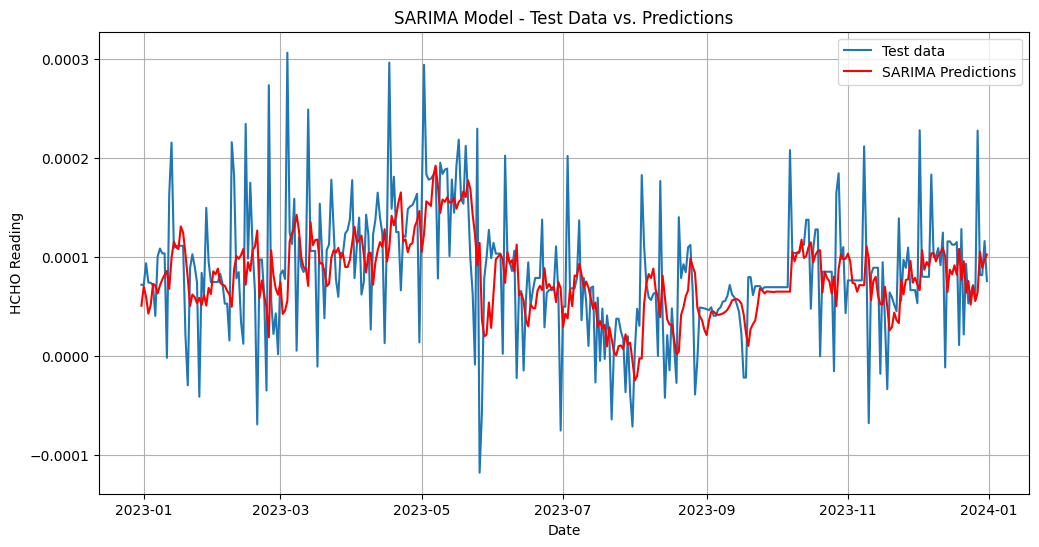

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.020017735812323e-05
Mean Squared Error (MSE): 3.6255613374741364e-09
R-squared (R2) Score: 0.08819538875570809
Root Mean Squared Error (RMSE): 6.021263436749912e-05
Median Absolute Error: 2.5965879680077106e-05
Explained Variance Score: 0.0967686385312263
